# Script for scraping games from USAU website

Daniel Walton, 3/14/2020

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import requests
import math
import re
import time
import collections
from bs4 import BeautifulSoup
from datetime import datetime

In [2]:
# Get some good colors for plotting
cmap = cm.get_cmap('Set1')
num_colors = 9
colors = {}
for i in range(num_colors):
    colors[i] = cmap((i+0.5)/num_colors)

In [3]:
# Handy way for storing scores
Score = collections.namedtuple('Score', ['team_a', 'team_b'])

# Format for game logs
GameLog = collections.namedtuple('GameLog', ['level','name','team_a_name','team_b_name',\
                                             'score','winner','loser',\
                                             'child_a','child_b','parent'])

In [4]:
"""
Querying the USAU website, like:

past/upcoming:  
https://play.usaultimate.org/events/tournament/?ViewAll=false&IsLeagueType=false
&IsClinic=false&FilterByCategory=AE&CompetitionLevelId=27&GenderDivisionId=17

all events view:
https://play.usaultimate.org/events/tournament/?ViewAll=true&IsLeagueType=false
&IsClinic=false&FilterByCategory=AE&CompetitionLevelId=27&GenderDivisionId=17

"""

'\nQuerying the USAU website, like:\n\npast/upcoming:  \nhttps://play.usaultimate.org/events/tournament/?ViewAll=false&IsLeagueType=false\n&IsClinic=false&FilterByCategory=AE&CompetitionLevelId=27&GenderDivisionId=17\n\nall events view:\nhttps://play.usaultimate.org/events/tournament/?ViewAll=true&IsLeagueType=false\n&IsClinic=false&FilterByCategory=AE&CompetitionLevelId=27&GenderDivisionId=17\n\n'

In [5]:
# Background:
#
# To validate the model, we want to see if we can use end-of-regular-season power
# ratings to predict the outcomes of the post-season.
#
# So, we grab the final regular season rankings/power ratings and all games from the
# post-season.  The post season includes the conference championships (a.k.a. sectionals),
# regionals, and nationals.  Nationals hasn't happened yet, so we will just be looking at
# sectionals and regionals data for the most part.
#
# We will perform cross-validation to tune the only parameter in our model p_a_offense,
# the probability of the higher rated team scoring a point when the start on offense.
# This parameter is currently set at 0.8 based on a small amount of observed data.  
# But, we can see if there is a better value.  The 0.8 value is based on Nationals quality 
# teams.  Since, the ultimate goal is to be able to predict nationals outcomes,
# we may want to limit the scope of this so we aren't trying to fit the value with a
# bunch of weak teams where results can be *much* more variable.
#
# Also, we want to grab College Nationals data, once that becomes available.

In [5]:
# Dates to use
#
# Will use last rankings set before the post season for 2019.
# These rankings were posted April 4, 2019.  I grabbed them May 22, 2019.
# Name	Status	Rank Set	Create Date	Links
# 2019 College Men's - Rankings April 4 - Final Rankings
# 2019 College Women's - Rankings April 4 - Final Rankings

regular_season_start_date = datetime(2020, 1, 1)
regular_season_end_date = datetime(2020, 3, 14)
final_regular_season_rankings_date = datetime(2020, 3, 14)
last_day_before_college_nationals = datetime(2020, 3, 14)

start_date = regular_season_start_date
end_date = regular_season_end_date

In [6]:
# Scrape rankings including href links for each team, 
# then go to each team's page and get all of their games.

In [34]:
womens_end_reg_season_ranking_html = r'Rankings/USAU_team_rankings.women.2020-03-11.html'
mens_end_reg_season_ranking_html   = r'Rankings/USAU_team_rankings.men.2020-03-11.html'

In [7]:
def get_team_rankings_and_page_links(url):
    """
    Get the rankings data, including power ratings from a the USAU website.
    
    Returns a dataframe with the data.
    """
    columns = ['Rank', 'Team', 'Power Rating', 'Competition Level',
               'Gender Division', 'Competition Division', 'College Region', 
               'College Conference', 'Wins', 'Losses', 'Link']
    
    url_prefix = r'https://play.usaultimate.org'
    
    with open(url,"r") as file:
        soup = BeautifulSoup(file, 'lxml')
        parsed_table = soup.find_all('table')[0] 
        data = [[''.join(td.stripped_strings) for td in row.find_all('td')] + 
                [url_prefix + td.a['href'] for td in row.find_all('td') if td.find('a')]
                for row in parsed_table.find_all('tr')]
        df = pd.DataFrame(data[1:], columns=columns)
        df.drop(index=[len(df)-2, len(df)-1], inplace=True)  

    # Make certain columns numeric
    cols = ['Rank', 'Power Rating', 'Wins', 'Losses']
    df[cols] = df[cols].apply(pd.to_numeric)
    
    return df

In [10]:
#
# Test get_team_rankings_and_page_links on women's rankings
#
url = r'Rankings/USAU_team_rankings.women.2020-03-11.html'

df_womens = get_team_rankings_and_page_links(url)

print(df_womens.head())

print(df_womens.loc[0].Link)
print(df_womens.loc[len(df_womens)-1].Link)

   Rank                  Team  Power Rating Competition Level Gender Division  \
0     1      Carleton College          2521           College           Women   
1     2        North Carolina          2495           College           Women   
2     3                 Tufts          2275           College           Women   
3     4  California-San Diego          2242           College           Women   
4     5            Washington          2151           College           Women   

  Competition Division  College Region        College Conference  Wins  \
0           Division I   North Central  Western North Central DI    12   
1           Division I  Atlantic Coast               Carolina DI    12   
2           Division I     New England           Metro Boston DI     9   
3           Division I       Southwest                  SoCal DI    17   
4           Division I       Northwest               Cascadia DI    10   

   Losses                                               Link  
0    

In [12]:
def str_to_score(score_string):
    """
    Convert a string to a score: '15-11' -> Score(team_a=15, team_b=11)
    
    Currently discards F - W (forfeit results)
    """
    
    numbers = score_string.split('-')
    if numbers[0]=='F ' and numbers[1]==' W':
        return np.nan 
    else:
        try:
            return Score(team_a=int(numbers[0]), team_b=int(numbers[1]))
        except:
            return np.nan

In [13]:
def get_team_game_scores(team_name, team_url, year, 
                         date_from=datetime(1900,1,1), 
                         date_to=datetime(2100,12,31)):
    """
    For a team name and team url (on USAU webpage), scrape the date, score, 
    and opponent into a pandas dataframe.
    
    Only return games in range [date_from, date_to], where date_from and date_to
    are datetime.datetime objects.
    
    Ignore games with F - W results and missing values.
    """
    # Read data
    df = pd.read_html(team_url)[1]
    
    # Rename columns
    df.rename(columns={0:'Date', 1:'Score', 2:'Opponent'}, inplace=True)
    
    # Drop rows that are actually tournament names
    rows_to_drop = [i for i in df.index.values if df.loc[i].Date==df.loc[i].Opponent]
    df.drop(rows_to_drop, axis=0, inplace=True)
    
    # Convert strings to scores
    df['Score']= df['Score'].apply(lambda x: str_to_score(x) if type(x)==str else np.nan)
    
    # Drop any nan results or F-W (forfeits?)
    df.dropna(subset=['Score'], inplace=True)
    
    # Change dates to datetime objects
    df['Date'] = df['Date'].apply(lambda x: datetime.strptime(x+', '+str(year), '%B %d, %Y'))
    
    # Only dates in range
    rows_to_drop = [i for i in df.index.values if (df.loc[i].Date < date_from) or 
                    (df.loc[i].Date > date_to)]
    df.drop(rows_to_drop, axis=0, inplace=True)
    
    # Add column with team name
    df['Team'] = [team_name]*len(df.index)
    
    return df[['Date', 'Team', 'Opponent', 'Score']]

In [16]:
# Tests for get_team_game_scores
unc_url = r'https://play.usaultimate.org/teams/events/Eventteam/?TeamId=3fVzVVhNsbuYuOI2A5RKsda8AA2DzTpROXdHemv1DYo%3d'
dartmouth_url = r'https://play.usaultimate.org/teams/events/Eventteam/?TeamId=WXjIRazqjTcHuQMSlzINJzzF94jL9TgKt0%2b2uDwZrlQ%3d'

df_unc = get_team_game_scores('North Carolina', unc_url, 2020, 
                              date_from=start_date,
                              date_to=end_date)
df_dartmouth = get_team_game_scores('Dartmouth', dartmouth_url, 2020, 
                              date_from=start_date,
                              date_to=end_date)

print(df_unc)
print(df_dartmouth)

         Date            Team           Opponent    Score
1  2020-02-08  North Carolina     William & Mary   (8, 5)
2  2020-02-08  North Carolina  Appalachian State  (13, 3)
3  2020-02-08  North Carolina       Georgia Tech  (13, 3)
4  2020-02-08  North Carolina         Pittsburgh  (11, 5)
5  2020-02-09  North Carolina         Ohio State  (13, 9)
6  2020-02-09  North Carolina   Carleton College  (9, 12)
8  2020-02-22  North Carolina       Northwestern  (15, 6)
9  2020-02-22  North Carolina       Northeastern  (15, 5)
10 2020-02-22  North Carolina         Pittsburgh  (11, 9)
11 2020-02-23  North Carolina            Oberlin  (15, 2)
12 2020-02-23  North Carolina           Virginia  (13, 8)
13 2020-02-23  North Carolina         Ohio State  (15, 9)
14 2020-02-23  North Carolina         Pittsburgh  (15, 8)
        Date       Team                   Opponent     Score
1 2020-01-18  Dartmouth              Florida State   (10, 8)
2 2020-01-18  Dartmouth              South Florida    (9, 5)
3 202

In [21]:
def get_all_scores_all_teams(ranking_url, year, 
                             date_from=datetime(1900,1,1), 
                             date_to=datetime(2100,1,1), 
                             rank_from=1, rank_to=np.inf, 
                             pause_time = 0):
    """
    Gets all scores from all games played by all teams in the rankings.
    
    Returns a dataframe with game data.
    
    Games *should* only appear once.  
    """
    
    rankings_data = get_team_rankings_and_page_links(ranking_url)
    
    list_of_df_to_concat = [] #Store each df and concat at the end
    
    for i in rankings_data.index.values:
        row = rankings_data.loc[i]
        
        # Is this team ranked in the desired range?
        # If so, then scrape data from the team page and append
        if (row.Rank >= rank_from) and (row.Rank <= rank_to):
            team_name = row.Team
            if pause_time > 0:
                time.sleep(pause_time) 
            print(row.Rank, team_name)
            team_url = row.Link
            
            this_teams_games = get_team_game_scores(team_name, team_url, year, 
                                                         date_from=date_from,
                                                         date_to=date_to)
            list_of_df_to_concat.append(this_teams_games)
    
    full_results = pd.concat(list_of_df_to_concat, ignore_index=True)
    
    # Merge in team rank, rating
    full_results = full_results.merge(rankings_data[['Team', 'Rank', 'Power Rating']], 
                                      on='Team', how='left')
    
    # Merge in opponent rank, rating
    full_results = full_results.merge(rankings_data[['Team', 'Rank', 'Power Rating']], 
                                      left_on='Opponent', right_on='Team', how='left',
                                      suffixes=('','_opp'))
    full_results.drop(columns=['Team_opp'], inplace=True)
    full_results.rename(columns={'Rank':'TeamRank', 'Power Rating':'TeamRating',
                                'Rank_opp':'OppRank', 'Power Rating_opp':'OppRating'},
                        inplace=True)
    
    full_results = full_results.reindex(columns=['Date','Team','TeamRank','TeamRating',
                                                 'Score','Opponent','OppRank','OppRating'])
    
    # Add the ratings difference and Victory margin in a game to 15
    full_results['RatingDiff'] = full_results['TeamRating'] - full_results['OppRating']
    full_results['GameTo15VictoryMargin'] = full_results['Score'].apply(lambda x: 15./np.max([x.team_a, x.team_b])*(x.team_a-x.team_b))
    
    # To make sure no results are in there twice, drop all results with negative Rating diff,
    # since if the game has a negative rating diff, then the higher ranked team would have 
    # already have the game logged.
    return full_results[full_results['RatingDiff']>=0]

In [53]:
# Decide which team's data to grab
rank_from, rank_to = 1, 10000

In [54]:
full_results_women = get_all_scores_all_teams(womens_end_reg_season_ranking_html, 2020, 
                                              date_from=start_date, 
                                              date_to=end_date, 
                                              rank_from=rank_from, 
                                              rank_to=rank_to, 
                                              pause_time=0.1)

1 Carleton College
2 North Carolina
3 Tufts
4 California-San Diego
5 Washington
6 Georgia Tech
7 Northeastern
8 Ohio State
9 Stanford
10 Dartmouth
11 Virginia
12 California-Santa Barbara
13 Pittsburgh
14 UCLA
15 Florida
16 Western Washington
17 British Columbia
18 South Carolina
19 Wisconsin
20 Colorado
21 Vermont
22 Northwestern
23 Minnesota
24 Georgia
25 Texas
26 California-Davis
27 Ohio
28 Michigan
29 Vanderbilt
30 California
31 Florida State
32 William & Mary
33 North Carolina State
34 James Madison
35 Utah
36 Brigham Young
37 Skidmore
38 West Chester
39 Duke
40 Cal Poly-SLO
41 Colorado College
42 George Washington
43 Boston University
44 Chicago
45 Whitman
46 Puget Sound
47 Pennsylvania
48 Alabama
49 Texas-Dallas
50 Mount Holyoke
51 New Mexico
52 Victoria
53 Kennesaw State
54 Columbia
55 Case Western Reserve
56 North Carolina-Wilmington
57 Kansas
58 California-Santa Cruz
59 Washington University
60 Oregon
61 Massachusetts
62 Penn State
63 Liberty
64 Mississippi
65 Bates
66 Carleto

In [56]:
full_results_men = get_all_scores_all_teams(mens_end_reg_season_ranking_html, 2020, 
                                              date_from=start_date, 
                                              date_to=end_date, 
                                              rank_from=rank_from, 
                                              rank_to=rank_to, 
                                              pause_time=0.1)

1 North Carolina
2 Washington
3 Cal Poly-SLO
4 Brigham Young
5 Colorado
6 Oregon
7 Ohio State
8 Massachusetts
9 Pittsburgh
10 Carleton College-CUT
11 Minnesota
12 British Columbia
13 Brown
14 Colorado State
15 California
16 UCLA
17 Michigan
18 Tufts
19 Oregon State
20 North Carolina-Wilmington
21 North Carolina State
22 Georgia
23 William & Mary
24 Vermont
25 Georgia Tech
26 South Carolina
27 California-Santa Barbara
28 Western Washington
29 Wisconsin
30 Texas-Dallas
31 Texas
32 Dartmouth
33 Northwestern
34 James Madison
35 Oklahoma State
36 California-Santa Cruz
37 Northeastern
38 Miami (Ohio)
39 California-San Diego
40 Santa Clara
41 Stanford
42 Utah
43 Alabama
44 Utah State
45 Notre Dame
46 Arizona
47 Auburn
48 Temple
49 Tulane
50 Tennessee
51 Purdue
52 Alabama-Huntsville
53 California-Davis
54 Case Western Reserve
55 Virginia Tech
56 Illinois
57 Virginia
58 Whitman
59 Embry-Riddle
60 Washington University
61 LSU
62 Cincinnati
63 Victoria
64 Florida
65 Georgetown
66 Occidental
67 Wi

In [55]:
# Save men's and women's data to csv file
womens_file_name = f'Results/results_womens_games_rank%i-%i_%s_to_%s.csv' %(rank_from,
                                               rank_to,
                                               start_date.strftime('%Y-%m-%d'),
                                               end_date.strftime('%Y-%m-%d'))

full_results_women.to_csv(womens_file_name)

In [57]:
# Save women's data to csv file
mens_file_name = f'Results/results_mens_games_rank%i-%i_%s_to_%s.csv' %(rank_from,
                                               rank_to,
                                               start_date.strftime('%Y-%m-%d'),
                                               end_date.strftime('%Y-%m-%d'))

full_results_men.to_csv(mens_file_name)

In [37]:
# No Nationals in 2020!  Sad :(


# # 
# # Get results after Nationals happen
# #
# womens_post_regionals_ranking_html = r'FullTeamRankings_women_post-regionals.htm'
# mens_post_regionals_ranking_html   = r'FullTeamRankings_men_post-regionals.htm'

# nationals_start_date = datetime(2019,5,24)
# nationals_end_date = datetime(2019,5,27)

In [38]:
# nationals_results_women = get_all_scores_all_teams(womens_post_regionals_ranking_html, 2019, 
#                                               date_from=nationals_start_date, 
#                                               date_to=nationals_end_date, 
#                                               rank_from=1, 
#                                               rank_to=53, 
#                                               pause_time=0.1)

In [39]:
# nationals_results_men = get_all_scores_all_teams(mens_post_regionals_ranking_html, 2019, 
#                                               date_from=nationals_start_date, 
#                                               date_to=nationals_end_date, 
#                                               rank_from=1, 
#                                               rank_to=80, 
#                                               pause_time=0.1)

In [40]:
# # Save men's and women's Nationals game data to csv files
# womens_file_name = f'results_womens_nationals_games_rank%i-%i_%s_to_%s.csv' %(rank_from,
#                                                rank_to,
#                                                start_date.strftime('%Y-%m-%d'),
#                                                end_date.strftime('%Y-%m-%d'))

# nationals_results_women.to_csv(womens_file_name)

# # Save women's data to csv file
# mens_file_name = f'results_mens_nationals_games_rank%i-%i_%s_to_%s.csv' %(rank_from,
#                                                rank_to,
#                                                start_date.strftime('%Y-%m-%d'),
#                                                end_date.strftime('%Y-%m-%d'))

# nationals_results_men.to_csv(mens_file_name)

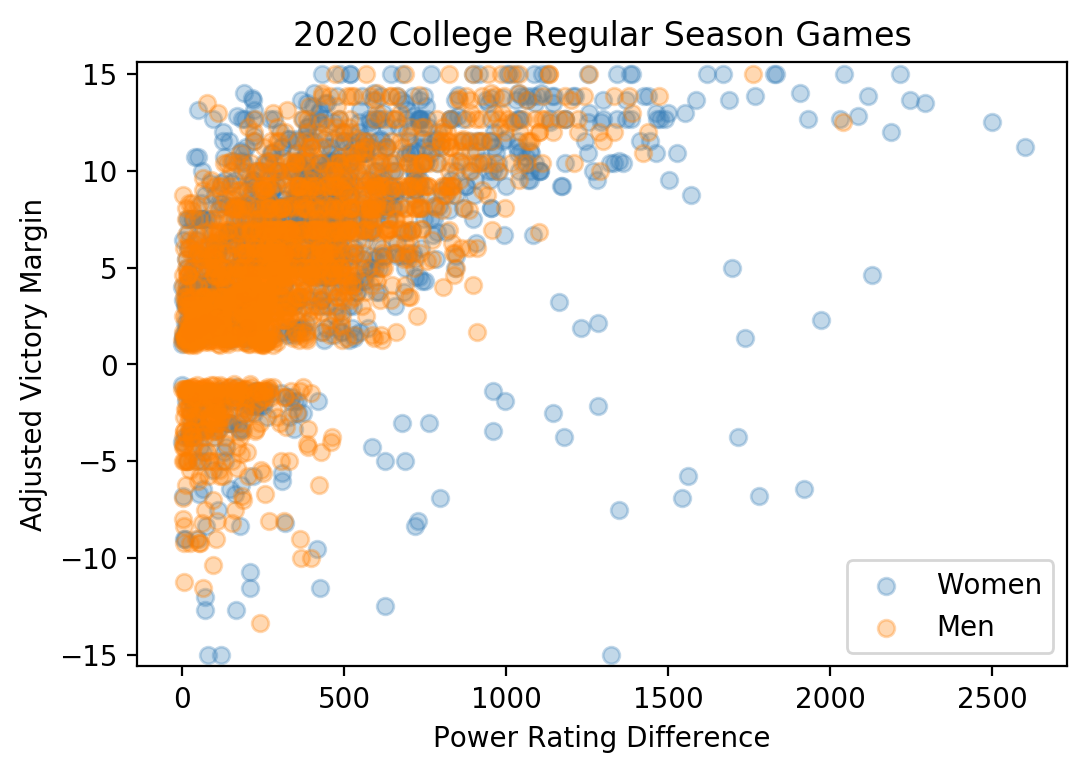

In [58]:
# Plot Women's and Men's REGULAR SEASON results together

fig = plt.figure(figsize=(6,4), dpi=200)
fig.patch.set_facecolor('white')
alpha = 0.3 # points
alpha_game = 0.6 # Game info ('Pitt 11-15 Victoria')
fontsize_game = 7
plt.scatter(full_results_women['RatingDiff'], 
            full_results_women['GameTo15VictoryMargin'], 
            label='Women', color=colors[1], alpha=alpha)
plt.scatter(full_results_men['RatingDiff'], 
            full_results_men['GameTo15VictoryMargin'], 
            label='Men', color=colors[4], alpha=alpha)

# Men
for i in full_results_men.index.values:
    rating_diff_here = full_results_men['RatingDiff'].loc[i]
    gameto15_victory_margin_here = full_results_men['GameTo15VictoryMargin'].loc[i]
    
    text = '%s %i-%i %s' %(full_results_men['Team'].loc[i], 
                           full_results_men['Score'].loc[i].team_a, 
                           full_results_men['Score'].loc[i].team_b, 
                           full_results_men['Opponent'].loc[i])
    
#     # Brown crushes UNC
#     if rating_diff_here >= 400 and gameto15_victory_margin_here <= -5:
#         plt.text(full_results_men['RatingDiff'].loc[i], 
#                 full_results_men['GameTo15VictoryMargin'].loc[i],
#                 text, horizontalalignment='left', verticalalignment='top',
#                 alpha=alpha_game, fontsize=fontsize_game)
#         plt.scatter(full_results_men['RatingDiff'].loc[i], 
#                     full_results_men['GameTo15VictoryMargin'].loc[i],
#                     marker='o', color=colors[4])


# Womens        
for i in full_results_women.index.values:
    rating_diff_here = full_results_women['RatingDiff'].loc[i]
    gameto15_victory_margin_here = full_results_women['GameTo15VictoryMargin'].loc[i]
    
    text = '%s %i-%i %s' %(full_results_women['Team'].loc[i], 
                           full_results_women['Score'].loc[i].team_a, 
                           full_results_women['Score'].loc[i].team_b, 
                           full_results_women['Opponent'].loc[i])
    
#     # UCSD loses to Tufts
#     if rating_diff_here >= 400 and gameto15_victory_margin_here <= -1:
#         plt.text(full_results_women['RatingDiff'].loc[i], 
#                 full_results_women['GameTo15VictoryMargin'].loc[i],
#                 text, horizontalalignment='left', verticalalignment='bottom',
#                 alpha=alpha_game, fontsize=fontsize_game)
#         plt.scatter(full_results_women['RatingDiff'].loc[i], 
#                     full_results_women['GameTo15VictoryMargin'].loc[i],
#                     marker='o', color=colors[1])


alpha_interpretation = 0.4
# plt.text(400,0, 'Surprise\nClose Game', color='gray', 
#          alpha=alpha_interpretation)
#plt.xlim([0, 1600])
plt.ylim([-15.6, 15.6])
plt.title("2020 College Regular Season Games")
plt.xlabel('Power Rating Difference')
plt.ylabel('Adjusted Victory Margin')
plt.legend(loc='lower right')
plt.show()

